This demonstrates all the steps in my candidate selection before conducting visual inspection

In [1]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import shapey
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wisps

import matplotlib as mpl


import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stars=wisps.Annotator.reformat_table(pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars'))

In [3]:
stars[wisps.INDEX_NAMES]=(stars[wisps.INDEX_NAMES].applymap(float))

In [4]:
cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf', key='with_indices')

In [5]:
cands[wisps.INDEX_NAMES]=(stars[stars.grism_id.isin(cands['grism_id'])])[wisps.INDEX_NAMES]

In [6]:
dt=stars[(stars.f_test< 0.4) &(stars.snr1>=3.)].reset_index(drop=True)

In [7]:
#(wisps.datasets['schneider'])[wisps.INDEX_NAMES]

In [8]:
gbhio=sel_crt.save_criteria(conts=dt)

  0%|          | 0/45 [00:00<?, ?it/s]

(2626, 25) (27, 25)


100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


In [9]:
crts=sel_crt.crts_from_file()

In [10]:
contamns=pd.DataFrame([ x.contamination for x in crts.values()])
compls=pd.DataFrame([ x.completeness for x in crts.values()])

In [11]:
contamns.index=[x for x in crts.keys()]
compls.index=[x for x in crts.keys()]

In [12]:
1/100, 10/100

(0.01, 0.1)

In [13]:
contamns.style.apply(lambda x: ["background-color: #7FDBFF" 
                          if (i >= 0 and (v < 0.07 
                                          and v > 0. )) 
                          else "" for i, v in enumerate(x)], axis = 1)

,L0-L5,L5-T0,M7-L0,T0-T5,T5-T9,subdwarfs,trash,Y dwarfs
H_2O-1/J-Cont H_2O-2/H_2O-1,0.0650466,0.121257,0.162739,0.019514,0.000859107,0.0587874,0.370029,0.00159548
H_2O-1/J-Cont H-cont/H_2O-1,0.102234,0.111561,0.17624,0.128621,0.0207413,0.0362052,0.363525,0.0137457
H_2O-1/J-Cont CH_4/H_2O-1,0.103584,0.123711,0.173417,0.0937653,0.00220913,0.0409917,0.354811,0.00662739
H_2O-1/J-Cont H_2O-2/J-Cont,0.0719195,0.123834,0.134634,0.0255277,0.000368189,0.0785469,0.348797,0.000859107
H_2O-1/J-Cont H-cont/J-Cont,0.0690967,0.0958517,0.155498,0.0979381,0.00429553,0.0385371,0.330511,0.00785469
H_2O-1/J-Cont CH_4/J-Cont,0.0731468,0.110702,0.153657,0.125184,0.00245459,0.0370643,0.326951,0.00110457
H_2O-1/J-Cont H-cont/H_2O-2,0.0922623,0.10727,0.140239,0.155616,0.0231271,0.0850043,0.304219,0.014762
H_2O-1/J-Cont CH_4/H_2O-2,0.0853734,0.068028,0.150695,0.100873,0.0230041,0.0879567,0.300406,0.014762
H_2O-1/J-Cont CH_4/H-Cont,0.044417,0.0539173,0.114621,0.109562,0.00209747,0.0594695,0.194201,0.000123381
H_2O-2/H_2O-1 H-cont/H_2O-1,0.324988,0.249018,0.388316,0.0660285,0.28326,0.065783,0.43164,0.978522


In [14]:
#templates['data_type']= 'templates'
all_spex=wisps.datasets['spex']
subdwarfs=all_spex[all_spex['metallicity_cls'] =='d/sd']

In [15]:
#compls.style.apply(lambda x: ["background-color: #7FDBFF" 
#                          if (i >= 0 and (v >.95 )) 
#                          else "" for i, v in enumerate(x)], axis = 1)

In [16]:
#%%capture
#for c in crts.values(): c.plot(save=True)

In [17]:
to_use={'H_2O-1/J-Cont H_2O-2/H_2O-1':'L0-L5',
        'H_2O-1/J-Cont CH_4/H-Cont':'L5-T0' ,
        'H_2O-1/J-Cont CH_4/H_2O-1':'M7-L0',
        'H_2O-2/J-Cont H-cont/J-Cont': 'T0-T5',
        'H_2O-2/J-Cont CH_4/H-Cont': 'T5-T9',
        'H_2O-2+CH_4/J-cont H_2O-1+CH_4/H-cont': 'Y dwarfs',
        'H_2O-1/J-Cont H-cont/J-Cont': 'subdwarfs'
       }
        

In [18]:
len(to_use)

7

In [19]:
def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [20]:
spex_df=(wisps.datasets['spex']).reset_index(drop=True)
manj=(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=(wisps.datasets['schneider']).reset_index(drop=True)

In [21]:
#schn.spt

In [22]:
cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf',key='with_indices')

In [23]:
cands_dff=wisps.Annotator.reformat_table(cands)

In [24]:
#cands_dff

In [25]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [26]:
#dt

In [27]:
fp={}

In [28]:
cands_dff=wisps.Annotator.reformat_table(cands)

In [29]:
cands_dff.drop_duplicates().shape

(359, 17)

In [30]:
cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())

In [31]:
stars.grism_id=stars.grism_id.apply(lambda x: x.lower())

In [32]:
cx=cands_dff[cands_dff.grism_id.isin(stars.grism_id)]

In [33]:
cy=stars[stars.grism_id.isin(cx.grism_id)]

In [34]:
idx=crts['H_2O-1/J-Cont H_2O-2/H_2O-1']

In [35]:
ydwarfs=wisps.add_ydwarf_index((manj[manj['spt'].apply(wisps.make_spt_number)>38].append(schn)).reset_index(drop=True))
subdwarfs=wisps.add_ydwarf_index(subdwarfs)
cands_dff=wisps.add_ydwarf_index(cands_dff)
dt=wisps.add_ydwarf_index(dt)
spex_df=wisps.add_ydwarf_index(spex_df)

In [36]:
ydwarfs=wisps.Annotator.reformat_table(ydwarfs)
subdwarfs=wisps.Annotator.reformat_table(subdwarfs)
cands_dff=wisps.Annotator.reformat_table(cands_dff)
dt=wisps.Annotator.reformat_table(dt)
spex_df=wisps.Annotator.reformat_table(spex_df)

In [37]:
def plot_index_box(index_name, box_name, ax):
    
    #get the index and the box
    idx=crts[index_name]
    bx=[x for x in idx.shapes if x.shape_name==box_name][0]
    
    xkey=idx.xkey
    ykey=idx.ykey

    to_use_df=spex_df
    if box_name.lower()=='y dwarfs':
        to_use_df=ydwarfs
    if box_name.lower()=='subdwarfs':
        to_use_df=subdwarfs
        to_use_df['spt']=17

    ax.scatter(dt[xkey].apply(float).values, dt[ykey].apply(float).values, marker='o', s=10., facecolors='none',  alpha=0.1,edgecolors='#AAAAAA')
    
    
    cands_slctd, cands_bools=bx._select(np.array([cands_dff[xkey].values,cands_dff[ykey].values]))
   
    trash_slctd, trsh_bools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
    
    
    cands_in_that_class_bool=(cands_dff[ cands_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    spexs_slctd_in_that_class_bool= (to_use_df).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    if box_name.lower()=='subdwarfs':
         spexs_slctd_in_that_class_bool=np.ones(len(to_use_df), dtype=bool)
    
    
    
    
    cands_in_that_class=np.array([cands_slctd[0][cands_in_that_class_bool], cands_slctd[1][cands_in_that_class_bool]])
    
    spexs_slctd_in_that_class=np.array([to_use_df[xkey][spexs_slctd_in_that_class_bool], to_use_df[ykey][spexs_slctd_in_that_class_bool]])

    ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1], facecolors='#0074D9',  label='SpeX', s=10.)
    
    ax.scatter(cands_dff[xkey], cands_dff[ykey], marker='x', facecolors='#111111', s=10.)
    
    
    ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker='x', facecolors='#FF851B', s=10, edgecolors='#2ECC40', label='candidates')
    
    
    bx.color='#2ECC40'
    bx.alpha=.1
    bx.plot(ax=ax, only_shape=True, highlight=False)
    
    
    ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=18)
    ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=18)
    
    ax.set_title(box_name, fontsize=18)
    
    xbuffer=np.nanstd(to_use_df[[xkey,ykey]])
    
    ax.set_xlim([ bx.xrange[0]-0.2*abs(np.ptp(bx.xrange)), bx.xrange[1]+0.2*abs(np.ptp(bx.xrange))])
    ax.set_ylim([ bx.yrange[0]-0.2*abs(np.ptp(bx.yrange)), bx.yrange[1]+0.2*abs(np.ptp(bx.yrange))])
    
    ax.minorticks_on()
    

    if (trash_slctd.shape[1])==0:
        fprate=0.0
    else:
        fprate=(trash_slctd.shape[1]- cands_slctd.shape[1])/trash_slctd.shape[1]
        if box_name.lower()=='subdwarfs':
                fprate=1.
    
    fp[box_name]=  fprate
    
    plt.tight_layout()
    
    return {str(box_name): bx}
    
    

In [38]:
to_use

{'H_2O-1/J-Cont H_2O-2/H_2O-1': 'L0-L5',
 'H_2O-1/J-Cont CH_4/H-Cont': 'L5-T0',
 'H_2O-1/J-Cont CH_4/H_2O-1': 'M7-L0',
 'H_2O-2/J-Cont H-cont/J-Cont': 'T0-T5',
 'H_2O-2/J-Cont CH_4/H-Cont': 'T5-T9',
 'H_2O-2+CH_4/J-cont H_2O-1+CH_4/H-cont': 'Y dwarfs',
 'H_2O-1/J-Cont H-cont/J-Cont': 'subdwarfs'}

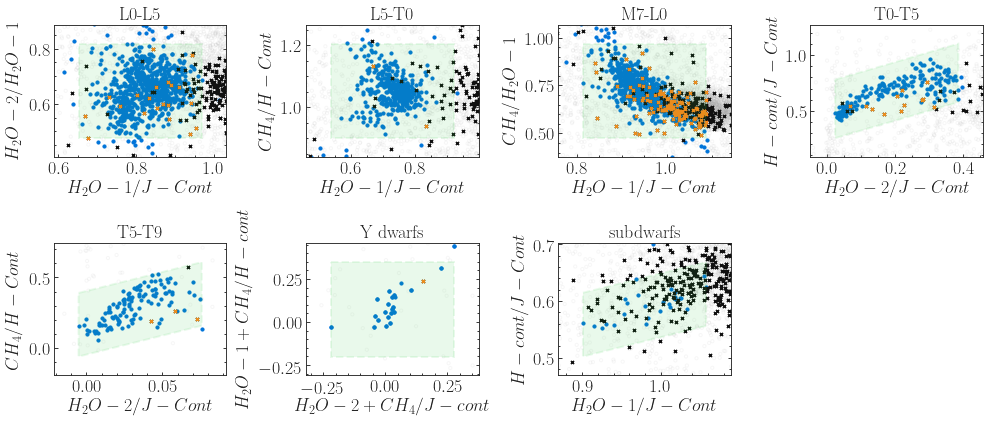

In [39]:
fig, ax=plt.subplots(nrows=2, ncols=4, figsize=(14, 6))

bxs=[]
for idx, k in enumerate(to_use.keys()):
    b=plot_index_box( k, to_use[k], np.concatenate(ax)[idx])
    bxs.append(b)
plt.tight_layout()
fig.delaxes(np.concatenate(ax)[-1])
#fig.delaxes(np.concatenate(ax)[-2])
plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.jpeg', bbox_inches='tight')

In [40]:
bx_dict={}
for b in bxs:
    bx_dict.update(b)

In [41]:
#invert to use
inv_to_use = {v: k for k, v in to_use.items()}

In [42]:
inv_to_use

{'L0-L5': 'H_2O-1/J-Cont H_2O-2/H_2O-1',
 'L5-T0': 'H_2O-1/J-Cont CH_4/H-Cont',
 'M7-L0': 'H_2O-1/J-Cont CH_4/H_2O-1',
 'T0-T5': 'H_2O-2/J-Cont H-cont/J-Cont',
 'T5-T9': 'H_2O-2/J-Cont CH_4/H-Cont',
 'Y dwarfs': 'H_2O-2+CH_4/J-cont H_2O-1+CH_4/H-cont',
 'subdwarfs': 'H_2O-1/J-Cont H-cont/J-Cont'}

In [43]:
from tqdm import tqdm

In [44]:
ncandidates=[]
for spt_range in bx_dict.keys():
    idx_name=inv_to_use[spt_range]
    idx=crts[idx_name]
    s, bools=(bx_dict[spt_range])._select(np.array([dt[idx.xkey].values, dt[idx.ykey].values]))
    print (spt_range, len(dt[bools]))
    ncandidates.append(dt[bools])

L0-L5 530
L5-T0 437
M7-L0 1413
T0-T5 160
T5-T9 14
Y dwarfs 19
subdwarfs 314


In [45]:
candsss=(pd.concat(ncandidates).drop_duplicates(subset='grism_id'))

In [46]:
len(candsss), len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>16)])

(2174, 134)

In [47]:
len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>19)])

32

In [48]:
candsss.to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [49]:
def round_tuple(tpl, n=2):
    return round(tpl[0], n), round(tpl[1],n)

In [50]:
inv_to_use

{'L0-L5': 'H_2O-1/J-Cont H_2O-2/H_2O-1',
 'L5-T0': 'H_2O-1/J-Cont CH_4/H-Cont',
 'M7-L0': 'H_2O-1/J-Cont CH_4/H_2O-1',
 'T0-T5': 'H_2O-2/J-Cont H-cont/J-Cont',
 'T5-T9': 'H_2O-2/J-Cont CH_4/H-Cont',
 'Y dwarfs': 'H_2O-2+CH_4/J-cont H_2O-1+CH_4/H-cont',
 'subdwarfs': 'H_2O-1/J-Cont H-cont/J-Cont'}

In [51]:
good_indices=[crts[x] for x in inv_to_use.values()]

In [52]:
for sindex, k in zip(good_indices, to_use.keys()):
   
    spt_range=to_use[k]
    bs=sindex.shapes
    bs=[x for x in bs if x.shape_name==spt_range]

    bx=bs[0]
    
    print (" {} & {} &  {} & {} & {} & {} & {} & {} & {}  & {} \\\ ".format(spt_range,sindex.xkey, sindex.ykey, 
                                                                           round_tuple(bx.vertices[0]), round_tuple(bx.vertices[1])
                                                                          , round_tuple(bx.vertices[2]), round_tuple(bx.vertices[3]),
                                                                          round(sindex.completeness[spt_range], 2), 
                                                                            round(sindex.contamination[spt_range], 3), 
                                                                           round(fp[spt_range], 2)))
    

 L0-L5 & H_2O-1/J-Cont &  H_2O-2/H_2O-1 & (0.65, 0.82) & (0.97, 0.82) & (0.97, 0.48) & (0.65, 0.48) & 0.97 & 0.065  & 0.9 \\ 
 L5-T0 & H_2O-1/J-Cont &  CH_4/H-Cont & (0.54, 1.21) & (0.92, 1.21) & (0.92, 0.9) & (0.54, 0.9) & 0.96 & 0.054  & 0.95 \\ 
 M7-L0 & H_2O-1/J-Cont &  CH_4/H_2O-1 & (0.81, 0.97) & (1.09, 0.97) & (1.09, 0.48) & (0.81, 0.48) & 0.96 & 0.173  & 0.81 \\ 
 T0-T5 & H_2O-2/J-Cont &  H-cont/J-Cont & (0.02, 0.78) & (0.39, 1.1) & (0.39, 0.58) & (0.02, 0.25) & 0.98 & 0.02  & 0.88 \\ 
 T5-T9 & H_2O-2/J-Cont &  CH_4/H-Cont & (-0.01, 0.39) & (0.08, 0.61) & (0.08, 0.16) & (-0.01, -0.06) & 0.98 & 0.002  & 0.71 \\ 
 Y dwarfs & H_2O-2+CH_4/J-cont &  H_2O-1+CH_4/H-cont & (-0.22, 0.35) & (0.28, 0.35) & (0.28, -0.2) & (-0.22, -0.2) & 0.93 & 0.002  & 0.95 \\ 
 subdwarfs & H_2O-1/J-Cont &  H-cont/J-Cont & (0.9, 0.61) & (1.06, 0.67) & (1.06, 0.56) & (0.9, 0.5) & 0.86 & 0.039  & 1.0 \\ 


In [53]:
all_stuff=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='all_phot_spec_data')

In [54]:
len(all_stuff)

271915

In [55]:
len(stars)/len(all_stuff)

0.407958369343361

In [56]:
stars_with_snr= stars[(stars.snr1>=3.)]

In [57]:
len(stars_with_snr)/len(stars), len(stars_with_snr)/len(all_stuff)

(0.3878391778599117, 0.1582222385671993)

In [58]:
stars_with_ftest=(stars[(stars.f_test< 0.4) &(stars.snr1>=3.)])

In [59]:
len(stars_with_ftest), len(stars_with_ftest)/len(stars_with_snr), len(stars_with_ftest)/len(stars),  len(stars_with_ftest)/len(all_stuff)

(8148, 0.1893870720312391, 0.07345172631389164, 0.029965246492470073)